## Appendix C

In [ ]:
!pip3 install numpy opencv-python matplotlib scikit-learn pandas

In [8]:
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# Read face image from zip file
faces = dict()
with zipfile.ZipFile("../assets/40_people_faces.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # we use OpenCV to decode the byte string into an array of pixels
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

File naming ex1: s1/1.pgm
File naming ex2: s1/10.pgm
File naming ex3: s1/2.pgm




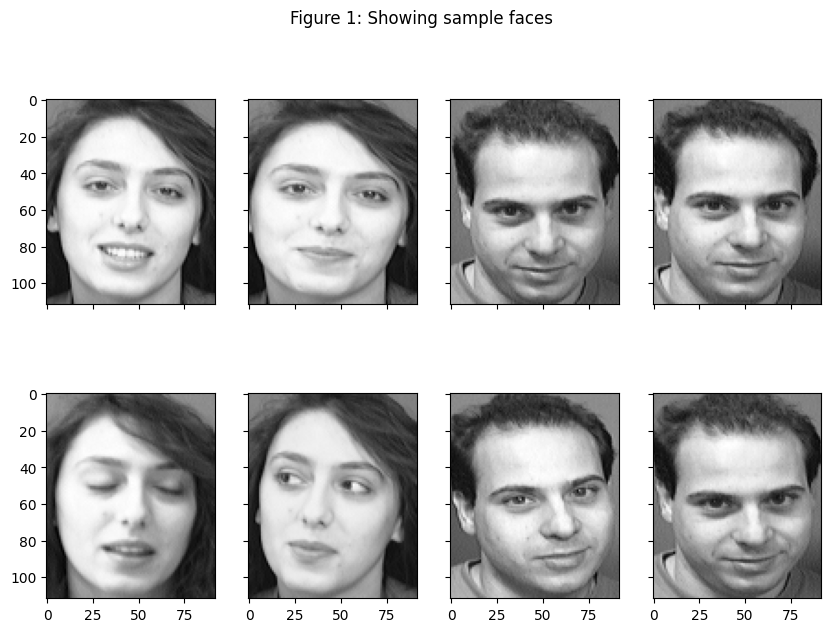

Face image shape: (112, 92)


In [11]:
# Show sample faces using matplotlib
img_number = 8
offset = 6

# showing the structure of the files
print("File naming ex1:", list(faces.keys())[0])
print("File naming ex2:", list(faces.keys())[1])
print("File naming ex3:", list(faces.keys())[2])
print('\n')

fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,7))
# take last N of images
face_images = list(faces.values())[-img_number-offset:-offset]

for i in range(img_number):
    axes[i%2][i//2].imshow(face_images[i], cmap="gray")

plt.suptitle('Figure 1: Showing sample faces')
plt.show()

# Print the pixel size of each picture
face_shape = list(faces.values())[0].shape
print("Face image shape:", face_shape)

In [14]:
# Separate images of 1-39 person and  eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
face_matrix = list()
person_face_label = list()
for key, val in faces.items():
    if key.startswith("s1/"):
        continue # this is our test set
    if key == "s28/10.pgm":
        continue # this is our test set
    face_matrix.append(val.flatten()) # save the images
    person_face_label.append(key.split("/")[0]) # save only the person number

# Create a NxM matrix with N images and M pixels per image
print('\n\t\tFigure 2: Matrix Representation of the Images\n')
face_matrix = np.array(face_matrix)
print(pd.DataFrame(face_matrix))



		Figure 2: Matrix Representation of the Images

     0      1      2      3      4      5      6      7      8      9      \
0      140    134    135    136    133    136    133    134    136    137   
1      133    129    133    130    130    132    129    132    128    133   
2      138    135    135    138    136    135    135    136    135    136   
3      137    135    136    136    136    138    136    126    139    128   
4      132    118    124    129    133    138    135    132    142    126   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
384    110    109    111    107    116    113    111    111    113    114   
385    113    112    111    113    115    115    111    114    115    114   
386    112    109    116    112    113    113    115    114    114    116   
387    111    114    112    112    110    112    111    114    112    112   
388    110    112    113    109    113    110    114    111    111    115   

     ...  10294  10295  1

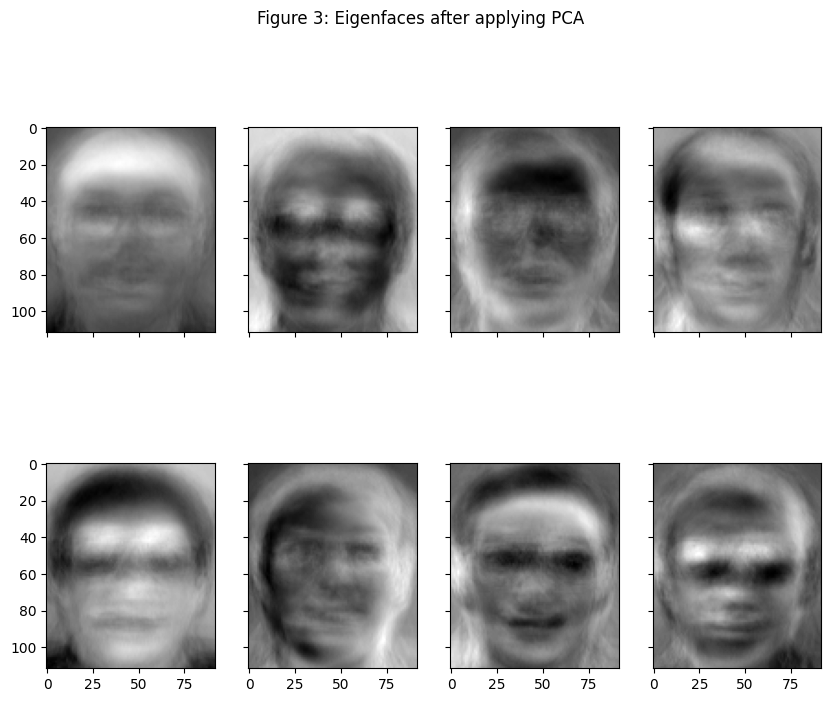

In [16]:
# Apply PCA, where each row represent an eigenvector/eigenface
# taking the first 50 eigenvectors (PC) with the highest eigenvalues
num_pc = 50
pca = PCA(n_components=num_pc).fit(face_matrix)

eigenfaces = pca.components_

# Show the first 8 eigenfaces/eigenvectors
fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,8))
for i in range(img_number):
    axes[i%(img_number//4)][i//(img_number//4)].imshow(
      eigenfaces[i].reshape(face_shape),
      cmap="gray")

plt.suptitle("Figure 3: Eigenfaces after applying PCA")
plt.show()

In [21]:
# printing the variance matrix (eigenvalues of each eigenvectors/principal component)

print('\n\t\tFigure 4: Variance Matrix\n')
print(pd.DataFrame(pca.explained_variance_ratio_))


		Figure 4: Variance Matrix

           0
0   0.170781
1   0.132518
2   0.069736
3   0.053070
4   0.050693
5   0.033911
6   0.024883
7   0.023752
8   0.020062
9   0.017830
10  0.014754
11  0.014275
12  0.011166
13  0.010764
14  0.009979
15  0.009306
16  0.008745
17  0.008438
18  0.007302
19  0.007058
20  0.006569
21  0.006346
22  0.005992
23  0.005488
24  0.005427
25  0.005065
26  0.004875
27  0.004652
28  0.004541
29  0.004447
30  0.004421
31  0.004088
32  0.003985
33  0.003774
34  0.003635
35  0.003529
36  0.003469
37  0.003352
38  0.003235
39  0.003030
40  0.002983
41  0.002919
42  0.002826
43  0.002720
44  0.002661
45  0.002547
46  0.002524
47  0.002463
48  0.002416
49  0.002335


In [23]:
# calculate the weight vector for each input picture and save it in
# 'weights' as a KxN matrix, where K is the number of eigenfaces and N
# the number of samples
weights = eigenfaces @ (face_matrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

Shape of the weight matrix: (50, 389)


Best match s28 with Euclidean distance 1910.123769


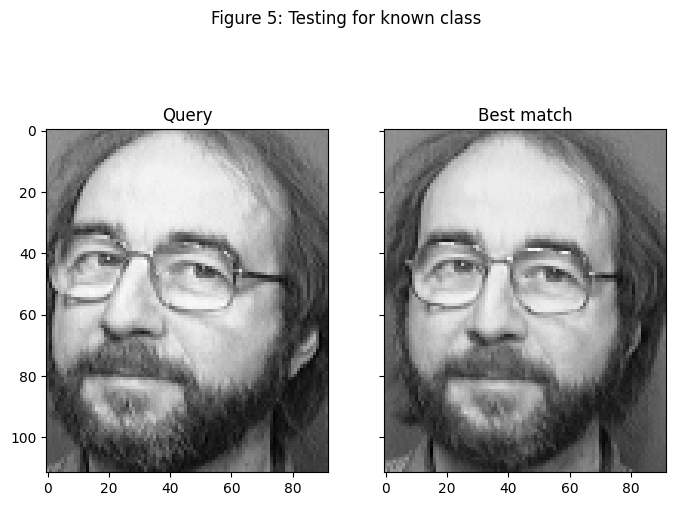

In [25]:
# Test on out-of-sample image of existing class
query = faces["s28/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (person_face_label[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(face_shape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(face_matrix[best_match].reshape(face_shape), cmap="gray")
axes[1].set_title("Best match")

plt.suptitle('Figure 5: Testing for known class')
plt.show()

Best match s13 with Euclidean distance 3645.336158


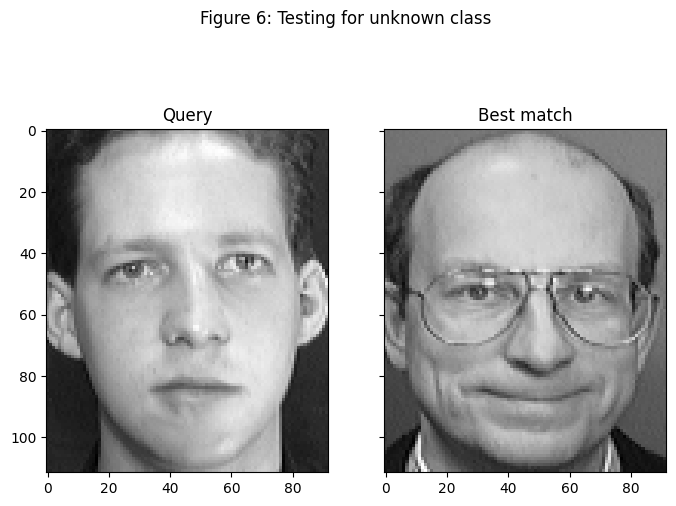

In [26]:
# Test on out-of-sample image of new class
query = faces["s1/8.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (person_face_label[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(face_shape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(face_matrix[best_match].reshape(face_shape), cmap="gray")
axes[1].set_title("Best match")

plt.suptitle('Figure 6: Testing for unknown class')
plt.show()